# Train and save a model

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
from keras.preprocessing import image
from keras.models import save_model

### Configuration

In [2]:
batch_size = 10
img_height = 128
img_width = 128
data_dir = os.path.join(os.getcwd(), 'images', 'handsigns')
testdata_dir = os.path.join(os.getcwd(), 'images', 'testimages')
class_names = None



### Images for training the model

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 3 classes.
Using 120 files for training.


### Images for validating the model

In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 3 classes.
Using 30 files for validation.


### Images for testing the model

In [5]:
#test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  #testdata_dir,
  #image_size=(img_height, img_width),
  #batch_size=batch_size)

### Save classnames to text file using pickle dump

In [6]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))
f = open("classnames.txt", "wb")
f.write(pickle.dumps(class_names))
f.close()


['apple', 'cucumber', 'tomat']
3


### Read saved class names by using pickle

In [7]:
classnames = pickle.loads(open('classnames.txt', "rb").read())
print(classnames)

['apple', 'cucumber', 'tomat']


### Display pictures from trained dataset

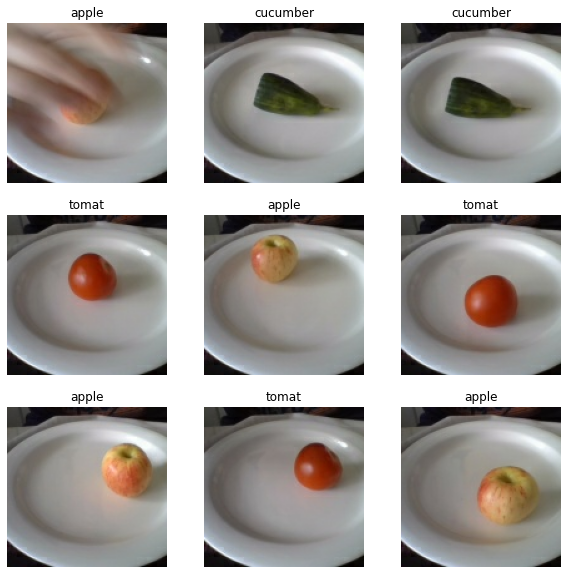

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Print info about tensors shape

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 128, 128, 3)
(10,)


### Standardize the data

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train the model

In [12]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)


Epoch 1/5
12/12 [==============================] - 3s 210ms/step - loss: 1.1453 - accuracy: 0.4167 - val_loss: 1.1297 - val_accuracy: 0.2333
Epoch 2/5
12/12 [==============================] - 2s 185ms/step - loss: 1.0999 - accuracy: 0.3000 - val_loss: 1.0673 - val_accuracy: 0.3667
Epoch 3/5
12/12 [==============================] - 2s 146ms/step - loss: 1.0115 - accuracy: 0.4500 - val_loss: 0.8429 - val_accuracy: 0.8000
Epoch 4/5
12/12 [==============================] - 2s 163ms/step - loss: 0.7497 - accuracy: 0.6500 - val_loss: 0.5412 - val_accuracy: 0.7333
Epoch 5/5
12/12 [==============================] - 2s 163ms/step - loss: 0.6260 - accuracy: 0.6417 - val_loss: 0.5830 - val_accuracy: 0.5667


### Test model accuracy with test pictures

In [13]:
#model.evaluate(test_ds)


In [14]:
### Visualize the testing for images in 'testimages' folder

apple 50.07 % ---- apple0d527b44-1867-11ec-80ba-98fa9b700496.jpg
cucumber 98.74 % ---- cucumber2042b8e8-1867-11ec-add9-98fa9b700496.jpg
apple 52.57 % ---- tomat17c61c11-1867-11ec-b01f-98fa9b700496.jpg


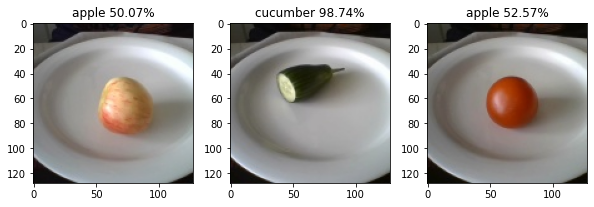

In [15]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
individual_pics_test_path = os.path.join(os.getcwd(), 'images', 'testimages')
pic_list = os.listdir(individual_pics_test_path)

plt.figure(figsize=(10, 10))

for count, picture in enumerate(pic_list):
    ax = plt.subplot(3, 3, count + 1)
    test_image_path = os.path.join(individual_pics_test_path, picture)
    test_image = image.load_img(test_image_path, (img_height,img_width))
    test_image = image.img_to_array(test_image)
    plt.imshow(test_image.astype("uint8"))
    test_image = np.expand_dims(test_image,axis=0)
    result = probability_model.predict(test_image)
    class_names[np.argmax(result)]
    plt.title(class_names[np.argmax(result)] + " " + str(round((np.amax(result)*100), 2)) + "%" )
    print(class_names[np.argmax(result)] + " " + str(round((np.amax(result)*100), 2)) + " % ---- " + picture)
    #training_set.class_indices




### 

### Save model

In [16]:
tf.keras.models.save_model(
  model, 'saved_model/mymodel')


INFO:tensorflow:Assets written to: saved_model/mymodel\assets
